Dataset [link](https://can01.safelinks.protection.outlook.com/?url=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1-6sd6E3cL8uWdNeO4xiXxLbTSYXSTiVr%3Fusp%3Dsharing&data=04%7C01%7Carash.gholami%40queensu.ca%7C92b180b5b67d475fb70e08d87b7f4305%7Cd61ecb3b38b142d582c4efb2838b925c%7C1%7C0%7C637395133804367020%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C1000&sdata=1ieR3E8llMblC0QMBtx1%2FpHS71RQuCxzdNQLmH0HJVU%3D&reserved=0)

Explanation: There are **49** users' data here. Naming is in the format of Username_ExperimentNumber. Please also note that it is unprocessed raw data, which includes a lot of noise etc. 

Experiment-1: **20** participants are involved in this task and the participants were asked to type **a story** from **a set** of short and simple stories from the American Literature https://americanliterature.com/100-great-short-stories for **four minutes**. The story was chosen randomly by the participants.

Experiment-2: 20 participants are involved in this task and for this data set, all the participants were asked to type the **same text** https://en.wikipedia.org/wiki/The_Adventures_of_Tom_Sawyer for **four minutes**. For each participant, almost the same amount of data is collected as Experiment-1. This dataset is important to be able to measure the quality of the features. The collection of this dataset is quite realistic since in a real case the users could be also asked to type a given text during their CA sessions. 

Experiment-3: The participants are asked to type **10 different pangram sentences**. Pangrams sentences contain** all 26 letters** of the alphabet. This data set is used to test how the **letter distribution** of text affects the result.

Experiment-4: **34** participants are involved in this task and the participants were instructed to imitate someone else's typing pattern by watching the prerecorded video of the other person. For these experiments, one of the participants was recorded on video while typing a short and simple sentence for **15 seconds** from a perspective that the hand motions, smartwatch, keyboard, and the screen could be seen. Although it was not required, the perspective allowed to infer what the victim was typing by watching. This dataset was primarily used to analyze the **attacking scenarios**. It is left to the participant to type the exact same text or imitate the hand movement of the victim.

-----------------------

I realized that you have mostly 4s and 10s as values on column A, but I also found 2s. What does column A represent? 
A represents the sensor type:
 
**10 for the accelerometer
4 for the gyroscope**
2 for the magnetic field sensor

You can find more info about sensors and constant values that are used to define the sensor type in these links:
- https://developer.android.com/guide/topics/sensors/sensors_overview
- https://developer.android.com/reference/android/hardware/Sensor#TYPE_LINEAR_ACCELERATION

Normally, I only collected and used accelerometer and gyroscope sensor data. Magnetometer data should not be in the dataset. If there is, that means it is an **outlier**.
 
Is column B the time stamp, is it recorded at 100HZ?

In an android app, you can set the sampling rate "SENSOR_DELAY_NORMAL, SENSOR_DELAY_UI, SENSOR_DELAY_GAME, or SENSOR_DELAY_FASTEST " 

As far as I remember I used **"SENSOR_DELAY_FASTEST" for all sensors**, but in practice, I had a lot of issues regarding this. They **don't give a constant sampling rate**. Every time I used they were giving different sampling rates. They were giving different sampling rates for two sessions of the same user, for different users, or for different sensors. Therefore, I would recommend using the one in the practice, which you can calculate using the timestamp and the sample count. 

On the paper you said you have recorded both accelerometer and gyro data; but you seem to only have one of them at a time on columns C, D, and F. I am guessing 10 on column A represents accelerometer and 4 gyro, but I could be wrong. 
Also, some rows have more columns, and start with 11 on column A. What do those represent?
Please see the explanation above. 
 

In short, I would really appreciate it if you could let me know information I need to know for working with the data.

Also, as these sensors were giving me a lot of headaches because they are really not stable, I needed to perform a lot of preprocessing. I **cleaned the outliers** before further processing. I also applied some other filtering techniques such as **moving average** to obtain more smooth data. Moreover, I needed to **clean the part the users are not performing typing operation from the beginning and end**, which you can see if you plot the values, i.e., the **user stops meaning no value and then big deviations, where the user takes off the smartwatch**.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

CORES = -1
SEED = 567

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install --upgrade pip
# !pip install python-docx
# !pip install antropy


from joblib import Parallel, delayed

import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
import math as math
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
from dataclasses import asdict
from sklearn import svm
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, accuracy_score, make_scorer, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.model_selection import KFold
from sklearn import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Ftrl, Nadam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import concatenate as keras_concat
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping




import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import iqr
from scipy.stats import median_absolute_deviation
from scipy.stats import mode
from scipy.signal import find_peaks
from scipy.signal import peak_widths
# from scipy.special import entr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
get_new_scaler_dict = {"StandardScaler": StandardScaler, "MinMaxScaler": MinMaxScaler, "Normalizer": Normalizer, 
                       "MaxAbsScaler": MaxAbsScaler, "RobustScaler": RobustScaler, "PowerTransformer": PowerTransformer}
from sklearn.preprocessing import normalize
from sklearn.metrics import auc
# import antropy as ant
import time
# import docx

# Global utitlity functions are in separate notebook
%run ./Classification_utility-functions.ipynb
%run ./SEED-CONSTANTS.ipynb


np.random.seed(SEED)
tf.random.set_seed(SEED)
print(f"Seed was set to: {SEED}")

print("Setup Complete")

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neural Networks utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
---------

In [3]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Experiments Parameter set. Used as identifier for charts etc.

    # Data / Splitting:
    frequency: int
    feature_cols: list  # Columns used as features
    max_subjects: int
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
#     exclude_subjects: list  # Don't load data from those users
    n_valid_train_subjects: int
    n_valid_test_subjects: int
    n_test_train_subjects: int
    n_test_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)

    # Reshaping
    window_size: int  # After resampling
    nn_step_width: int
    ocsvm_step_width: int

    # Normalization
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # scale training and testing sets at once (True), or fit scaler on training only (False)

    # Siamese Network
    max_pairs_per_session: int  # Max. number of pairs per session
    margin: float  # Contrastive Loss Margin
    model_variant: str  # {"1d", "2d"} Type of architecture
    filters: list  # List of length 4, containing number of filters for conv layers
    epochs_best: int  # Train epochs to for final model
    epochs_max: int
    batch_size: int
    optimizer: str  # Optimizer to use for Siamese Network
    optimizer_lr: float  # Learning Rate
    optimizer_decay: float

    # OCSVM
    ocsvm_kernel: str # ocsvm kernel
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model

    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )


# INSTANCES
# ===========================================================

# NAIVE_MINMAX (2D Filters)
# -----------------------------------------------------------
NAIVE_MINMAX_2D = ExperimentParameters(
    name="NAIVE-MINMAX-2D",
#     # Data / Splitting
    frequency=100,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z"
    ],
    max_subjects=29,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    n_valid_train_subjects=40,
    n_valid_test_subjects=10,
    n_test_train_subjects=10,
    n_test_test_subjects=30,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,
    task_types=None,
    # Reshaping
    window_size=100 * 1,  #1 sec
    nn_step_width=125,
    ocsvm_step_width=125,
    # Normalization
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    # Siamese Network
    model_variant="2d",
    filters=[32, 64, 128, 32],
#     filters=[32, 64, 128, 64],
    epochs_best=35,
    epochs_max=40,
    batch_size=200,
    optimizer="sgd",
    optimizer_lr=0.01,
    optimizer_decay=0,
    max_pairs_per_session=60,  # => 4min
    margin=0.2,
    # OCSVM
    ocsvm_kernel="rbf",
    ocsvm_nu=0.092,
    ocsvm_gamma=1.151,
)  # <END NAIVE_APPROACH>

# VALID_MINMAX (2D)
# -----------------------------------------------------------
VALID_MINMAX_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-MINMAX-2D",
    task_types=None,
    scaler_global=False,
    epochs_max=40,
    ocsvm_nu=0.110,
    ocsvm_gamma=59.636,
)

# NAIVE_ROBUST (2D)
# -----------------------------------------------------------
NAIVE_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="NAIVE-ROBUST-2D",
    scaler="robust",
    optimizer="sgd",
    optimizer_lr=0.05, # Decreased, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    epochs_best=5,
    ocsvm_nu=0.214,
    ocsvm_gamma=2.354,
)

# VALID_ROBUST (2D)
# -----------------------------------------------------------
VALID_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-2D",
    scaler="robust",
    scaler_global=False,
    epochs_best=6,
    epochs_max=20,
    optimizer="sgd",
    optimizer_lr=0.05,  # Decrease LR, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    ocsvm_nu=0.190,
    ocsvm_gamma=0.069,
)

# VALID_ROBUST (1D)
# -----------------------------------------------------------
VALID_ROBUST_1D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-1D",
    scaler="robust",
    scaler_global=False,
    model_variant="1d", 
    filters=[32, 64, 128, 64],    
    epochs_best=9,
    epochs_max=20,
    ocsvm_nu=0.156,
    ocsvm_gamma=33.932,
)

# FCN_ROBUST (1D)
# -----------------------------------------------------------
VALID_FCN_ROBUST_125 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=125,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_250 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=250,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_500 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=500,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_750 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=750,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_1000 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1000,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_1250 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1250,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)


VALID_FCN_ROBUST_1500 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1500,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_1750 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1750,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)


VALID_FCN_ROBUST_2000 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=2000,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

In [4]:
P = VALID_FCN_ROBUST_2000
# utils_ppp(P)
# P = VALID_ROBUST_1D
# utils_ppp(P)
# P = NAIVE_MINMAX_2D

In [5]:
P.nn_step_width = int(P.window_size * .5)
P.ocsvm_step_width = int(P.window_size * .5)
P.scaler = 'RobustScaler'
# P.scaler = 'MinMaxScaler'
# P.scaler = 'Normalizer'
# P.scaler = 'StandardScaler'

utils_ppp(P)


,Value
name,VALID-FCN-ROBUST-FINAL
frequency,100
feature_cols,"[acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z]"
max_subjects,29
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
n_valid_train_subjects,40
n_valid_test_subjects,10


### 1.4 Select Approach <a id='1.4'>&nbsp;</a> 
Select the parameters to use for current notebook execution here!

# Split Dataset for Valid/Test  
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

They did a 30 60 split.

# Reshaping Raw Features.
We have our own function of windows for this. Do this for both training and testing.

# Extracting time and frequency based features.
Again, we have a function for this. Do this for both training and testing.

# Hyperparameter Optimization 

I do not find any reaqsonable explaination how to use a cross-validation as we are talking about anomaly detection.

I am using the experiment 1 data as train, and experiment 2 data as validation.

# Using SVM in a real-world Scenario with multiple genuine users and intruders
Source: https://datascience.stackexchange.com/questions/23623/what-is-the-best-way-to-classify-data-not-belonging-to-set-of-classes

Stage 1: 
    Use one-class SVM to assign those images that do not belong to the set of predefined classes as the 9-th class.

Stage 2:
    For those images that passes through your filter, let the multi-class SVM assign them to one of the 8 classes.

In [6]:
# P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx = 500, -3500
# P.num_sample_points_per_exp = 15000

Loading data:

In [7]:
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:
1) accel_count: 28388, gyro_count: 31997
2) accel_count: 26010, gyro_count: 28954
3) accel_count: 28227, gyro_count: 31814
4) accel_count: 24860, gyro_count: 26105
5) accel_count: 24270, gyro_count: 24347
6) accel_count: 25012, gyro_count: 25060
7) accel_count: 25301, gyro_count: 25382
8) accel_count: 21975, gyro_count: 21658
19) accel_count: 24110, gyro_count: 25050
21) accel_count: 24326, gyro_count: 23809
22) accel_count: 29123, gyro_count: 28724
26) accel_count: 23148, gyro_count: 24291
27) accel_count: 24299, gyro_count: 23589
28) accel_count: 23807, gyro_count: 24523
29) accel_count: 24030, gyro_count: 23457
35) accel_count: 24388, gyro_count: 23673
36) accel_count: 24228, gyro_count: 24208
37) accel_count: 31945, gyro_count: 31816
38) accel_count: 22135, gyro_count: 22327
39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296
41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328
43) accel_count: 22631,

In [8]:
P.smoothing = "FFT"

# Smoothing and Preprocessing

In [9]:
raw_dfList_exp1 = dfList_exp1
raw_dfList_exp2 = dfList_exp2

In [10]:

raw_dfList_exp2[0].dtypes
# np.array([1.0,2.0,3.0]).dtype

time_stamp    float32
x_a           float32
y_a           float32
z_a           float32
x_g           float32
y_g           float32
z_g           float32
dtype: object

<AxesSubplot:>

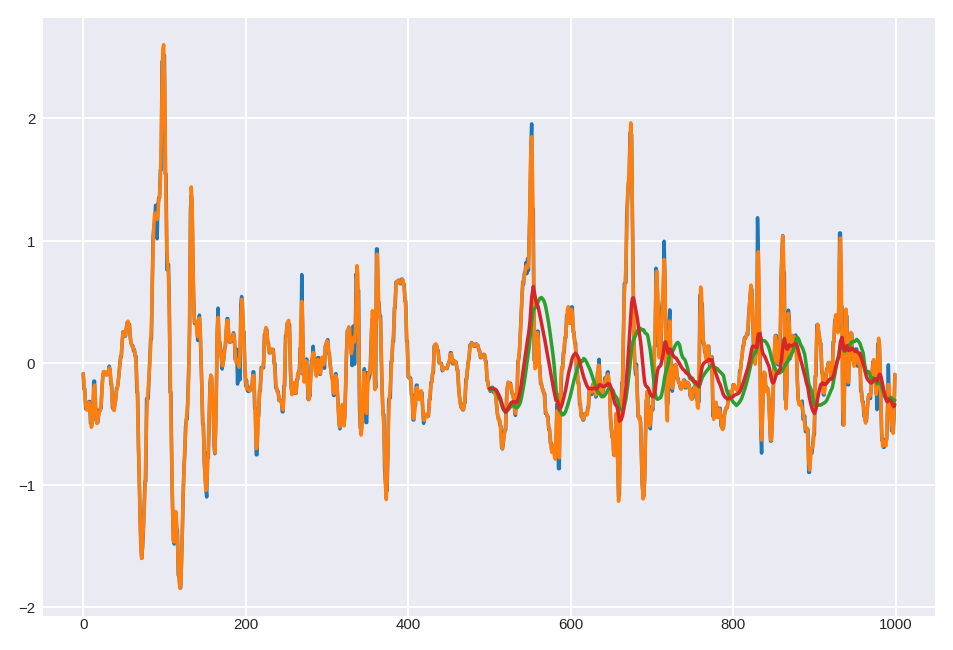

In [11]:
P.smoothing = "FFT"
P.cut_off_freq=25
ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
raw_dfList_exp2[0]['x_a'][0:1000].plot()
ffted_dfList_exp2[0]['x_a'][0:1000].plot()
# get_ffted_dfList([raw_dfList_exp2[0][raw_dfList_exp2[0].columns][500:1000]], cut_off_freq=P.cut_off_freq, filter_order=10)[0]['EMA_x_a'].plot()
dfList_exp1 = ffted_dfList_exp1
dfList_exp2 = ffted_dfList_exp2

P.span=49
# P.smoothing = "FFT+EMA"
# # raw_dfList_exp1 = dfList_exp1
# # raw_dfList_exp2 = dfList_exp2
# P.cut_off_freq=42
# ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
# ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
# ffted_dfList_exp2[0]['EMA_x_a'][500:1000].plot()
EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=P.span)
EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=P.span)
# EMAed_dfList_exp2[0]['EMA_x_a'][500:1000].plot()
# dfList_exp1 = EMAed_dfList_exp1
# dfList_exp2 = EMAed_dfList_exp2
raw_dfList_exp2[0]['x_a'][500:1000].rolling(window=30, min_periods=0).mean()[:].plot()
raw_dfList_exp2[0]['x_a'][500:1000].ewm(span=30, adjust=False).mean()[:].plot()

In [12]:
EMAed_dfList_exp2[0].dtypes

time_stamp    float32
x_a           float32
y_a           float32
z_a           float32
x_g           float32
y_g           float32
z_g           float32
dtype: object

In [13]:
P.cut_off_freq

25

In [14]:
randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
print(f"train_set: {train_set}\ntest_set: {test_set}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


In [15]:
train_set

[7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]

In [16]:
# train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
# test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]

In [17]:
P.num_sample_points_per_exp
print(len(train_set))
print(len(P.user_ids))

19
29


# CNN

Loading exp1 data:
47) accel_count: 22777, gyro_count: 22226
Loading exp2 data:
47) accel_count: 17718, gyro_count: 18353
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
len(X_exp1_dict_user_47[47]): 20
len_exp2_user_47: 17
user_47_idx: 29
np.unique(all_user_set): [ 1  2  3  4  5  6  7  8 19 21 22 26 27 28 29 35 36 37 38 39 40 41 42 43
 44 45 46 48 49]
X_exp1_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
X_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
fitted_scaler_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
len(exp1_df_train_dict): 20
len(exp2_df_train_dict): 20
len(exp1_df_user_set_dict): 10
len(exp2_df_user_set_dict): 10
len(X_test_exp1_dict): 10
len(X_test_exp2_dict): 10


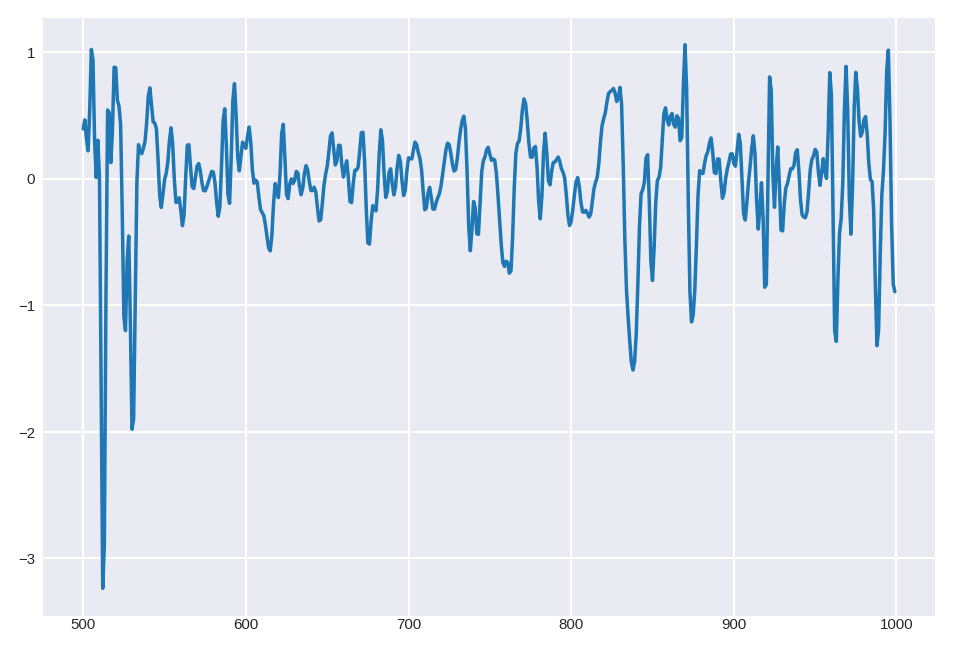

In [18]:
num_sample_points_per_exp_user_47 = 18000
df_exps_dict_user_47 = load_data_frames([47], P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

raw_dfList_exp1_user_47 = dfList_exp1_user_47
raw_dfList_exp2_user_47 = dfList_exp2_user_47

ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=P.cut_off_freq, filter_order=10, filtfilt=1)
ffted_dfList_exp2_user_47[0]['x_a'][500:1000].plot()
dfList_exp1_user_47 = ffted_dfList_exp1_user_47
dfList_exp2_user_47 = ffted_dfList_exp2_user_47
# EMAed_dfList_exp1_user_47 = get_EMAed_dfList(ffted_dfList_exp1_user_47, span=P.span)
# EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
# EMAed_dfList_exp2_user_47[0]['EMA_x_a'][500:1000].plot()
# dfList_exp1_user_47 = EMAed_dfList_exp1_user_47
# dfList_exp2_user_47 = EMAed_dfList_exp2_user_47

# preparing train data


X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_SNN_train_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.nn_step_width, train_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_SNN_train_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, P.window_size, P.nn_step_width, 
                                                                                                  scaler=P.scaler, num_sample_points_per_exp=P.num_sample_points_per_exp, 
                                                                                                  EMA_per_win_span=None, SMA_per_win_winsize=None)

X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_SNN_train_exp2_dict=append_user_47_to_data(X_train_exp1_dict, X_train_exp2_dict, fitted_scaler_SNN_train_exp2_dict, P.user_ids, 
                                                                                               X_train_exp1_dict_user_47, X_train_exp2_dict_user_47, fitted_scaler_SNN_train_exp2_dict_user_47, verbose=1)

print(f"len(exp1_df_train_dict): {len(X_train_exp1_dict)}")
print(f"len(exp2_df_train_dict): {len(X_train_exp2_dict)}")


# preparing test data
X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, P.window_size, P.ocsvm_step_width, test_set, 
                                                                    P.scaler, P.num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

print(f"len(X_test_exp1_dict): {len(X_test_exp1_dict)}")
print(f"len(X_test_exp2_dict): {len(X_test_exp2_dict)}")

In [19]:
# df_exps_dict_user_47 = load_data_frames([47], P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
# dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

In [20]:
# dfList_exp1_user_47[0].hist(bins=100, column='EMA_x_a')
# dfList_exp1_user_47[0].hist(bins=100, column='EMA_y_a')
# dfList_exp1_user_47[0].hist(bins=100, column='EMA_z_a')
# dfList_exp1_user_47[0].hist(bins=100, column='EMA_x_g')
# dfList_exp1_user_47[0].hist(bins=100, column='EMA_y_g')
# dfList_exp1_user_47[0].hist(bins=100, column='EMA_z_g')

# dfList_exp2_user_47[0].hist(bins=100, column='EMA_x_a')
# dfList_exp2_user_47[0].hist(bins=100, column='EMA_y_a')
# dfList_exp2_user_47[0].hist(bins=100, column='EMA_z_a')
# dfList_exp2_user_47[0].hist(bins=100, column='EMA_x_g')
# dfList_exp2_user_47[0].hist(bins=100, column='EMA_y_g')
# dfList_exp2_user_47[0].hist(bins=100, column='EMA_z_g')
# raw_dfList_exp2_user_47[0]["EMA_x_a"].plot()

In [21]:
# visualize distro
all_exp1 = pd.concat(dfList_exp1)
all_exp2 = pd.concat(dfList_exp2)


In [22]:
# all_exp1.hist(bins=100, column='x_a')
# all_exp1.hist(bins=100, column='y_a')
# all_exp1.hist(bins=100, column='z_a')
# all_exp1.hist(bins=100, column='x_g')
# all_exp1.hist(bins=100, column='y_g')
# all_exp1.hist(bins=100, column='z_g')

# all_exp2.hist(bins=100, column='x_a')
# all_exp2.hist(bins=100, column='y_a')
# all_exp2.hist(bins=100, column='z_a')
# all_exp2.hist(bins=100, column='x_g')
# all_exp2.hist(bins=100, column='y_g')
# all_exp2.hist(bins=100, column='z_g')

**Overview of current Experiment Parameters:**

#### Euclidead distance

#### Inspect Model Architecture

In [23]:
spliter = 2*len(X_train_exp2_dict)//3
cnn_train_exp2 = {key: X_train_exp2_dict[key] for key in list(X_train_exp2_dict.keys())[:spliter]}
cnn_train_exp1 = {key: X_train_exp1_dict[key] for key in list(X_train_exp1_dict.keys())[:spliter]}
cnn_valid_exp2 = {key: X_train_exp2_dict[key] for key in list(X_train_exp2_dict.keys())[spliter:]}
cnn_valid_exp1 = {key: X_train_exp1_dict[key] for key in list(X_train_exp1_dict.keys())[spliter:]}

In [24]:
print(f"train set: {cnn_train_exp2.keys()}\nvalidation set: {cnn_valid_exp2.keys()}")
print(f"train set: {cnn_train_exp1.keys()}\nvalidation set: {cnn_valid_exp1.keys()}")

train set: dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6])
validation set: dict_keys([25, 16, 1, 17, 27, 5, 29])
train set: dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6])
validation set: dict_keys([25, 16, 1, 17, 27, 5, 29])


In [25]:
fitted_scaler_SNN_train_exp2_dict.keys()

dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])

In [26]:
cnn_train_exp1.keys()

dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6])

In [27]:
# %run ./utility-functions.ipynb

# P.model_variant = 'multi_input'

# tf.random.set_seed(SEED)
# create_model_func = get_create_model_func_multi_input(P.model_variant, P.window_size, P.feature_cols, 3)
# num_input=3
# single_head_2layercnn_2layerdense_SCNN_arg_dict_default = {
#     "input_dropout_streams": [0.2 for i in range(num_input)],
#     "filters_streams": [[128, 64] for i in range(num_input)],
#     "kernels_streams": [[5, 3] for i in range(num_input)],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform"] for i in range(num_input)],
#     "kernels_Max_Norm_constraint_streams": [[3, 3] for i in range(num_input)],
#     "conv_kernel_regularizer_streams": [["l1","l2"] for i in range(num_input)],
#     "strides_streams": [[1, 1] for i in range(num_input)],
#     "paddings_streams": [["same", "same"] for i in range(num_input)],
#     "dropouts_streams": [[0.2, 0.2] for i in range(num_input)],
#     "activations_streams": [['relu', 'relu'] for i in range(num_input)],
    
#     "dense_layers": [84, 84],
#     "dense_kernel_Max_Norm_constraints": [3, 3],
#     "dense_kernel_regularizer":["l1", "l2"],
#     "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
#     "dense_dropouts": [0.2, 0.2], 
#     "dense_activations": ['swish', "sigmoid"],
    
#     "loss_func_name": "k_contrastive_loss",
#     "contrastive_loss_margin": 1.0,
    
#     "optimizer_name": "Adam",
#     "optimizer_lr": 1e-3,
#     "optimizer_decay": None,
    
#     "batch_size": 64,
    
    
#     "Training_samples": str(np.unique(y_train, return_counts=True)),
#     "Validation_samples": str(np.unique(y_valid, return_counts=True)),
#     "smoothing": P.smoothing if P.smoothing!=None else None,
#     # "EMA_span": P.span if "EMA" in P.smoothing else None ,
#     "Butter_cut_off_freq": P.cut_off_freq if P.cut_off_freq!=None else P.cut_off_freq,
#     "scaler": P.scaler,

# }

# arg_dict=single_head_2layercnn_2layerdense_SCNN_arg_dict_default
# arg_dict

In [28]:
# K.clear_session()
# tf.compat.v1.reset_default_graph()
# del history
# del model



In [29]:

    
    
# lr_pool = np.logspace(-5, -2, num=10)
# lr_pool=[1e-5]#, 2e-5]
# lr_epoch_log_dict={}
# ReduceLROnPlateau_err_mode={}
# ReduceLROnPlateau_args={'mointored_metric': "val_loss", "factor": 0.2, "patience": 0, "verbose": 1, "min_lr": 1e-8}
# ReduceLROnPlateau_args=ReduceLROnPlateau_args
# for lr in lr_pool:
#     tf.random.set_seed(SEED)
#     arg_dict['optimizer_lr'] = lr
#     print(lr)
#     print(arg_dict)
#     loss_record_dict = {'loss': [], 'val_loss': []}
#     metric_record_dict = {}
#     model = create_model_func(arg_dict)

#     # Train
#     history = model.fit(
#         x=X_train,
#         y=y_train,
#         batch_size=arg_dict["batch_size"],
#         epochs=200,
#         verbose=1,
#         validation_data=(X_valid, y_valid),
#         shuffle=True,
#         callbacks=[MetricsCallback_multi_input((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=1, 
#                                    loss_record_dict=loss_record_dict, metric_record_dict=metric_record_dict, 
#                                    save_plots=True, print_interm_epochs=True, early_stoping=False,
#                                   ReduceLROnPlateau_args=ReduceLROnPlateau_args, lr_epoch_log_dict=lr_epoch_log_dict)]#, reduce_lr],
#     )
#     print(loss_record_dict)
#     print("Training History:")
#     loss_fig = utils_plot_training_loss(loss_record_dict)
    
#     del model
#     del history
#     K.clear_session()
#     tf.compat.v1.reset_default_graph()

In [30]:
(1)

1

In [31]:
warnings.filterwarnings("ignore")

# why dont i get equal neg and pos pairs???
num_pair_limit_train_2000 = 10348
num_pair_limit_valid_2000 = 5614
num_pair_limit_train_125 = 8*num_pair_limit_train_2000
num_pair_limit_valid_125 = 8*num_pair_limit_valid_2000
# num_pair_limit_train_2000 = 18000
# num_pair_limit_valid_2000 = 14000
num_pair_limit_train_2000 = 28000
num_pair_limit_valid_2000 = 14000
# num_pair_limit_train_2000 = 999999999
# num_pair_limit_valid_2000 = 999999999
# num_pair_limit_train_2000 = 20000
# num_pair_limit_valid_2000 = 10000
# num_pair_limit_train_2000 = 40000
# num_pair_limit_valid_2000 = 20000
num_pair_limit_train_2000 = 10348
num_pair_limit_valid_2000 = 5614
train_pairs_dict = prep_X_y_pair(cnn_train_exp2, cnn_train_exp1, list(cnn_train_exp2.keys()), fitted_scaler_SNN_train_exp2_dict, num_pair_limit=num_pair_limit_train_2000)
X_train, y_train, X_train_distro_dic = train_pairs_dict["X"], train_pairs_dict["y"], train_pairs_dict["X_dic"]

valid_pairs_dict = prep_X_y_pair(cnn_valid_exp2, cnn_valid_exp1, list(cnn_valid_exp2.keys()), fitted_scaler_SNN_train_exp2_dict, num_pair_limit=num_pair_limit_valid_2000)
X_valid, y_valid, X_valid_distro_dic = valid_pairs_dict["X"], valid_pairs_dict["y"], valid_pairs_dict["X_dic"]
# X_final_train, y_train = prep_X_y_pair(Raw_X_exp2_train_dic, Raw_X_exp1_train_dic, list(Raw_X_exp2_train_dic.keys()), fitted_scaler_SNN_train_exp2_dict, num_pair_limit=num_pair_limit_train_2000)

# 2D Filter Model needs flat 4th dimension
if P.model_variant == "2d":
    X_train[0] = X_train[0].reshape((*X_train[0].shape, 1))
    X_train[1] = X_train[1].reshape((*X_train[1].shape, 1))
    X_valid[0] = X_valid[0].reshape((*X_valid[0].shape, 1))
    X_valid[1] = X_valid[1].reshape((*X_valid[1].shape, 1))

print(
    f"Training samples:   {y_train.shape[0]}, shape: {X_train[0].shape},"
    + f" class balance: {np.unique(y_train, return_counts=True)}"
)
print(
    f"Validation samples: {y_valid.shape[0]}, shape: {X_valid[0].shape},"
    + f" class balance: {np.unique(y_valid, return_counts=True)}"
    + f" class balance: {y_valid.shape}"
)
data_dict = {}
data_dict["X_valid"], data_dict["y_valid"], data_dict["X_train"], data_dict["y_train"] = X_valid, y_valid, X_train, y_train

100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Training samples:   10322, shape: (10322, 2000, 6), class balance: (array([0., 1.], dtype=float32), array([5148, 5174]))
Validation samples: 5614, shape: (5614, 2000, 6), class balance: (array([0., 1.], dtype=float32), array([2814, 2800])) class balance: (5614, 1)


In [32]:
X_left = np.concatenate([X_train[0], X_valid[0]])
X_right = np.concatenate([X_train[1], X_valid[1]])
y_train_valid = np.concatenate([y_train, y_valid])

X_left, X_right, y_train_valid = sklearn_shuffle(X_left, X_right, y_train_valid, random_state=SEED)

X_train_valid = [X_left, X_right]


In [33]:
print(X_train[0].dtype)
print(X_valid[0].dtype)
print(X_train[1].dtype)
print(X_valid[1].dtype)
print(X_train_valid[0].dtype)
print(X_train_valid[1].dtype)
print(y_train_valid.dtype)


float32
float32
float32
float32
float32
float32
float32


In [34]:
X_train_distro_dic["negative_pairs_dic"].keys()

dict_keys([(7, 24), (7, 8), (7, 11), (7, 13), (7, 19), (7, 28), (7, 21), (7, 26), (7, 3), (7, 20), (7, 22), (7, 6), (24, 7), (24, 8), (24, 11), (24, 13), (24, 19), (24, 28), (24, 21), (24, 26), (24, 3), (24, 20), (24, 22), (24, 6), (8, 7), (8, 24), (8, 11), (8, 13), (8, 19), (8, 28), (8, 21), (8, 26), (8, 3), (8, 20), (8, 22), (8, 6), (11, 7), (11, 24), (11, 8), (11, 13), (11, 19), (11, 28), (11, 21), (11, 26), (11, 3), (11, 20), (11, 22), (11, 6), (13, 7), (13, 24), (13, 8), (13, 11), (13, 19), (13, 28), (13, 21), (13, 26), (13, 3), (13, 20), (13, 22), (13, 6), (19, 7), (19, 24), (19, 8), (19, 11), (19, 13), (19, 28), (19, 21), (19, 26), (19, 3), (19, 20), (19, 22), (19, 6), (28, 7), (28, 24), (28, 8), (28, 11), (28, 13), (28, 19), (28, 21), (28, 26), (28, 3), (28, 20), (28, 22), (28, 6), (21, 7), (21, 24), (21, 8), (21, 11), (21, 13), (21, 19), (21, 28), (21, 26), (21, 3), (21, 20), (21, 22), (21, 6), (26, 7), (26, 24), (26, 8), (26, 11), (26, 13), (26, 19), (26, 28), (26, 21), (26, 

In [35]:
X_train_distro_dic["negative_pairs_dic"].keys()

# X_train_distro_dic["total_pairs_dic"] = {user_key: np.concatenate([X_train_distro_dic["positive_pairs_dic"][user_key], X_train_distro_dic["negative_pairs_dic"][user_key]], axis=0) 
#                                          for user_key in X_train_distro_dic["positive_pairs_dic"].keys()}
# X_valid_distro_dic["total_pairs_dic"] = {user_key: np.concatenate([X_valid_distro_dic["positive_pairs_dic"][user_key], X_valid_distro_dic["negative_pairs_dic"][user_key]], axis=0) 
#                                          for user_key in X_valid_distro_dic["positive_pairs_dic"].keys()}

X_train_valid_dic = {
    "positive_pairs_dic": {**X_train_distro_dic["positive_pairs_dic"], **X_valid_distro_dic["positive_pairs_dic"]},
                    }

X_train_valid_dic["positive_pairs_dic"][7].shape

(398, 2, 2000, 6)

In [36]:
# 802 * len(get_distro_count_dict(X_valid_distro_dic))

NameError: name 'get_distro_count_dict' is not defined

In [39]:
def get_user_distro_count_dict(X_distro_dict):
    X_distro_count_dic = {}    
    for owner_key in X_distro_dict["positive_pairs_dic"].keys():
        X_distro_count_dic[owner_key] = X_distro_dict["positive_pairs_dic"][owner_key].shape[0]
        X_distro_count_dic[owner_key] += np.concatenate([X_distro_dict["negative_pairs_dic"][user_key_pairs] 
                                                for user_key_pairs in X_distro_dict["negative_pairs_dic"].keys() 
                                                if user_key_pairs[0]==owner_key], axis=0).shape[0]
        
    return X_distro_count_dic


user_distro_count_dict = {**get_user_distro_count_dict(X_train_distro_dic), **get_user_distro_count_dict(X_valid_distro_dic)}
user_distro_count_dict

{7: 794,
 24: 794,
 8: 794,
 11: 794,
 13: 794,
 19: 794,
 28: 794,
 21: 794,
 26: 794,
 3: 794,
 20: 794,
 22: 794,
 6: 794,
 25: 802,
 16: 802,
 1: 802,
 17: 802,
 27: 802,
 5: 802,
 29: 802}

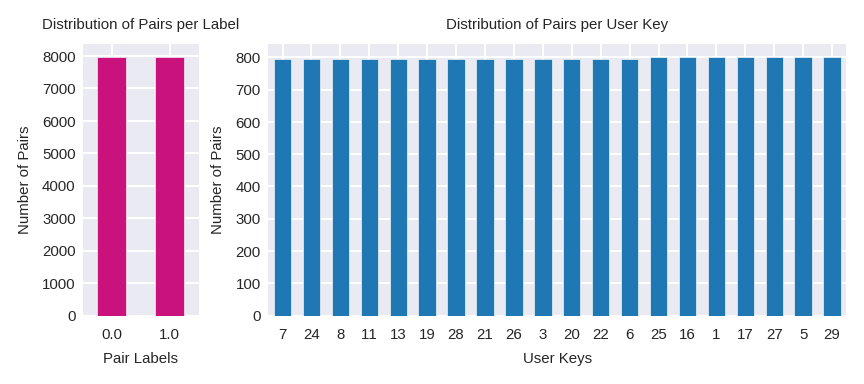

In [91]:
pair_labels, label_distro = np.unique(y_train_valid, return_counts=True)
user_keys = list(user_distro_count_dict.keys())
num_pairs = [num_pairs for num_pairs in user_distro_count_dict.values()]

fig, axes = plt.subplots(
    ncols=2, nrows=1, figsize=(5.473, 2), dpi=180, gridspec_kw={"width_ratios": [1, 5]}
)

bar_width = .5

x_index=np.arange(len(pair_labels))
axes[0].bar(x_index, label_distro, width=bar_width, color=MAGENTA)

# Set labels for axes
axes[0].set_xlabel('Pair Labels')
axes[0].set_ylabel('Number of Pairs')

# Set the title for the plot
axes[0].set_title('Distribution of Pairs per Label')

# Set x-axis ticks and labels
axes[0].set_xticks(x_index)
axes[0].set_xticklabels(pair_labels)

# Rotate X-axis labels and set the alignment
plt.xticks(rotation=0, ha='center')

axes[0].tick_params(axis="x", which="major", pad=5)
# Adjust x-axis limits
axes[0].set_xlim(-0.5, len(x_index)-0.5)

# Create a bar plot
# Set the bar width
bar_width = 0.6

x_index=np.arange(len(user_keys))
axes[1].bar(x_index, num_pairs, width=bar_width)

# Set labels for axes
axes[1].set_xlabel('User Keys')
axes[1].set_ylabel('Number of Pairs')

# Set the title for the plot
axes[1].set_title('Distribution of Pairs per User Key')

# Set x-axis ticks and labels
axes[1].set_xticks(x_index)
axes[1].set_xticklabels(user_keys)

# Rotate X-axis labels and set the alignment
plt.xticks(rotation=0, ha='center')

axes[1].tick_params(axis="x", which="major", pad=5)

# Adjust x-axis limits
axes[1].set_xlim(-0.5, len(x_index)-0.5)


# Display the plot
plt.show()

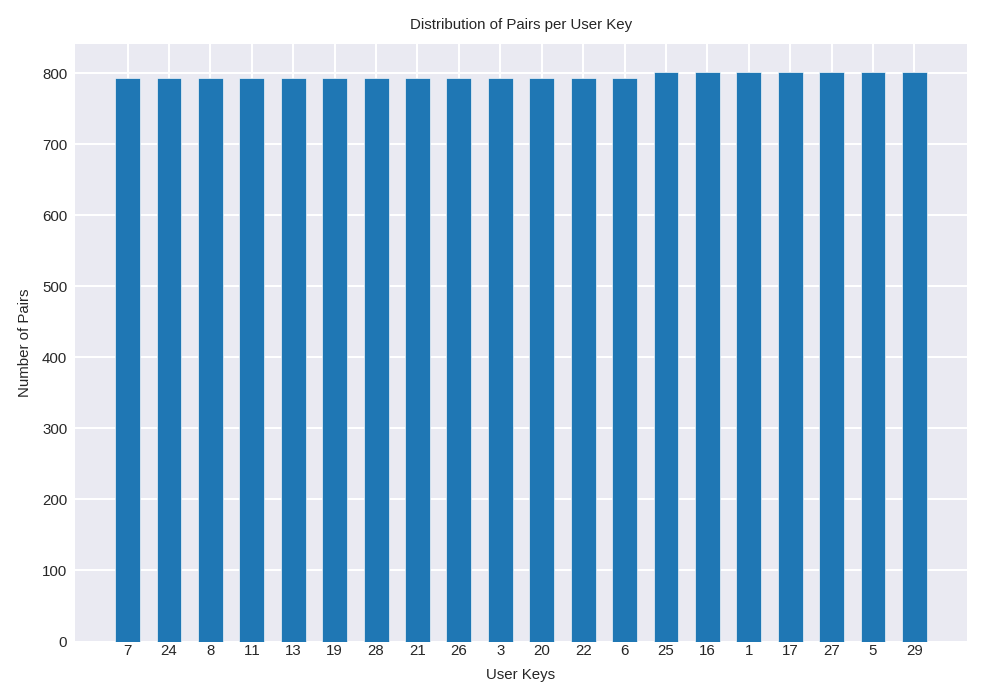

In [63]:
# Extract user_keys and number of pairs per user
user_keys = list(user_distro_count_dict.keys())
num_pairs = [num_pairs for num_pairs in user_distro_count_dict.values()]

# Create a bar plot
# Set the bar width
bar_width = 0.6

x_index=np.arange(len(user_keys))
fig, ax = plt.subplots()
ax.bar(x_index, num_pairs, width=bar_width)

# Set labels for axes
ax.set_xlabel('User Keys')
ax.set_ylabel('Number of Pairs')

# Set the title for the plot
ax.set_title('Distribution of Pairs per User Key')

# Set x-axis ticks and labels
ax.set_xticks(x_index)
ax.set_xticklabels(user_keys)

# Rotate X-axis labels and set the alignment
plt.xticks(rotation=0, ha='center')

# Display the plot
plt.show()

In [67]:
print(np.unique(y_train_valid, return_counts=True))

(array([0., 1.], dtype=float32), array([7962, 7974]))


(array([0., 1.], dtype=float32), array([7962, 7974]))


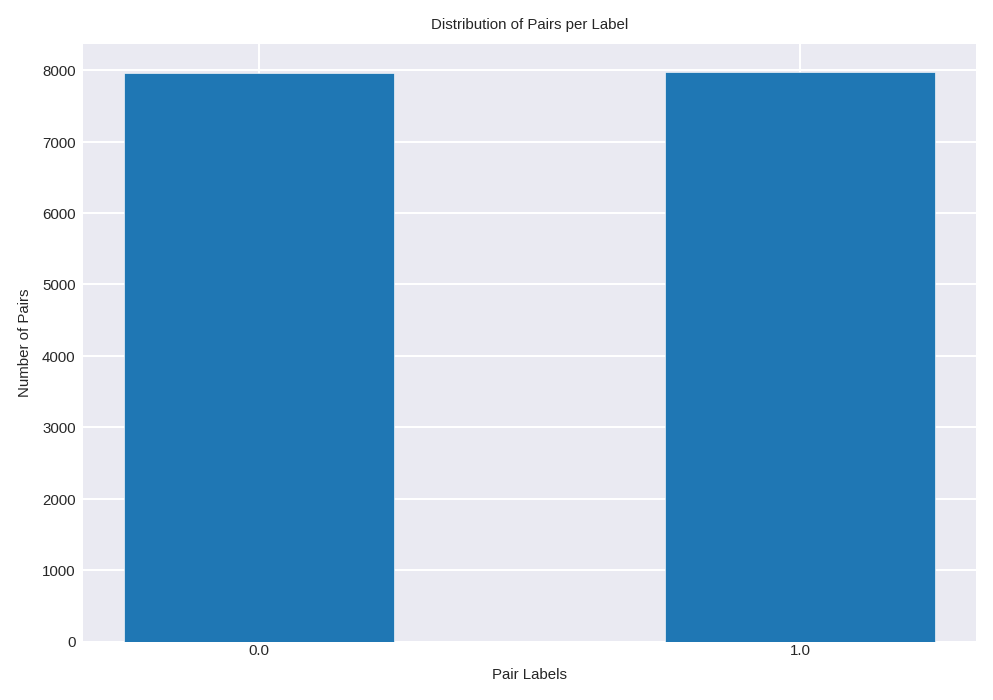

In [64]:
# Extract user_keys and number of pairs per user
user_keys, num_pairs = np.unique(y_train_valid, return_counts=True)

# Create a bar plot
# Set the bar width
bar_width = .5

x_index=np.arange(len(user_keys))
fig, ax = plt.subplots()
ax.bar(x_index, num_pairs, width=bar_width)

# Set labels for axes
ax.set_xlabel('Pair Labels')
ax.set_ylabel('Number of Pairs')

# Set the title for the plot
ax.set_title('Distribution of Pairs per Label')

# Set x-axis ticks and labels
ax.set_xticks(x_index)
ax.set_xticklabels(user_keys)

# Rotate X-axis labels and set the alignment
plt.xticks(rotation=0, ha='center')

# Display the plot
plt.show()

### 4.4 Search optimal Epoch <a id='4.4'>&nbsp;</a> 

In [ ]:
# model.summary()
np.array(X_train).shape

In [ ]:
# P.model_variant = 'fcn'
# P.model_variant = 'multi_head_fcn'
# P.model_variant
# model = create_model_func(filters, kernels, strides, dropouts, activations, dense, loss_func, 
#                           optimizer)

In [ ]:
utils_ppp(P)

In [ ]:
# P.span
P.smoothing
# P.cut_off_freq
# P.scaler

In [ ]:
P.model_variant = 'multi_head_fcn'
P.tuning_metric="eer_val"

# arg_dict_default = {
#     "input_dropout_streams": [0.2, 0.2],
#     "filters_streams": [[32, 32, 32], [32, 32, 32]],
#     "kernels_streams": [[7, 7, 7], [5, 5, 5]],
#     "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"], ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
#     "kernels_constraint_streams": [[MaxNorm(3), MaxNorm(3), MaxNorm(3)], [MaxNorm(3), MaxNorm(3), MaxNorm(3)]],
#     "strides_streams": [[1, 1, 1], [1, 1, 1]],
#     "paddings_streams": [["same", "same", "same"], ["same", "same", "same"]],
#     "dropouts_streams": [[.1, .1, .1], [.1, .1, .1]],
#     "activations_streams": [['relu', 'relu', 'relu'], ['relu', 'relu', 'relu']],
    
#     "dense_layers": [32, 32],
#     "dense_kernel_constraints":[MaxNorm(3), MaxNorm(3)],
#     "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
#     "dense_dropouts": [0.2, 0.2], 
#     "dense_activations": ["relu", "sigmoid"],
    
#     "loss_func": k_contrastive_loss,
#     "optimizer": "Adam",
#     "batch_size": 512,
# }
three_head_1layer_SCNN_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2], #5**3
    "filters_streams": [[64], [64], [64]], #6**3
    "kernels_streams": [[7], [5], [3]], #4*3
    "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform"], #8**3
                             ["glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3], [3]], #3**3
    "conv_kernel_regularizer_streams": [["l1"],["l2"], ["l1"]],
    "strides_streams": [[1], [1], [1]], #4**3
    "paddings_streams": [["same"], ["same"], ["same"]], #2*3
    "dropouts_streams": [[.1], [.1], [.1]], #5**3
    "activations_streams": [['relu'], ['relu'], ['relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 64,
    
    
    "Training_samples": str(np.unique(y_train, return_counts=True)),
    "Validation_samples": str(np.unique(y_valid, return_counts=True)),
    "smoothing": P.smoothing if P.smoothing!=None else None,
    # "EMA_span": P.span if "EMA" in P.smoothing else None ,
    "Butter_cut_off_freq": P.cut_off_freq if P.cut_off_freq!=None else P.cut_off_freq,
    "scaler": P.scaler,
}

three_head_123layer_SCNN_arg_dict_default = {
    "input_dropout_streams": [.2, .2, .2], #5**3
    "filters_streams": [[64], [128, 64], [256, 128, 64]], #6**3
    "kernels_streams": [[3], [5, 3], [7, 5, 3]], #4*3
    "kernels_init_streams": [["glorot_uniform"], ["glorot_uniform", "glorot_uniform"], #8**3
                             ["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3], [3, 3], [3, 3, 3]], #3**3
    "conv_kernel_regularizer_streams": [["l1"], ["l2","l1"], ["l1","l2", "l1"]],
    "strides_streams": [[1], [1, 1], [1, 1, 1]], #4**3
    "paddings_streams": [["same"], ["same", "same"], ["same", "same", "same"]], #2*3
    "dropouts_streams": [[.4], [.3, .4], [.2, .3, .4]], #5**3
    "activations_streams": [['relu'], ['relu', 'relu'], ['relu', 'relu', 'relu']], # 8**3
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,

    "optimizer_name": "Nadam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 256,
    
    
    "Training_samples": str(np.unique(y_train, return_counts=True)),
    "Validation_samples": str(np.unique(y_valid, return_counts=True)),
    "smoothing": P.smoothing if P.smoothing!=None else None,
    # "EMA_span": P.span if "EMA" in P.smoothing else None ,
    "Butter_cut_off_freq": P.cut_off_freq if P.cut_off_freq!=None else P.cut_off_freq,
    "scaler": P.scaler,
}


single_head_SCNN_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[512, 256, 128]],
    "kernels_streams": [[7, 5, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3, 3]],
    "conv_kernel_regularizer_streams": [["l1","l2", "l1"]],
    "strides_streams": [[1, 1, 1]],
    "paddings_streams": [["same", "same", "same"]],
    "dropouts_streams": [[0.3, 0.4, 0.5]],
    "activations_streams": [['relu', 'relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints":[3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],

    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 64,
    
    
    "Training_samples": str(np.unique(y_train, return_counts=True)),
    "Validation_samples": str(np.unique(y_valid, return_counts=True)),
    "smoothing": P.smoothing if P.smoothing!=None else None,
    # "EMA_span": P.span if "EMA" in P.smoothing else None ,
    "Butter_cut_off_freq": P.cut_off_freq if P.cut_off_freq!=None else P.cut_off_freq,
    "scaler": P.scaler,

}

single_head_2layer_SCNN_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[32, 64]],
    "kernels_streams": [[5, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3]],
    "conv_kernel_regularizer_streams": [["l1","l2"]],
    "strides_streams": [[1, 1]],
    "paddings_streams": [["same", "same"]],
    "dropouts_streams": [[0.2, 0.2]],
    "activations_streams": [['relu', 'relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints": [3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 64,
    
    
    "Training_samples": str(np.unique(y_train, return_counts=True)),
    "Validation_samples": str(np.unique(y_valid, return_counts=True)),
    "smoothing": P.smoothing if P.smoothing!=None else None,
    # "EMA_span": P.span if "EMA" in P.smoothing else None ,
    "Butter_cut_off_freq": P.cut_off_freq if P.cut_off_freq!=None else P.cut_off_freq,
    "scaler": P.scaler,

}

single_head_1layer_SCNN_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[64]],
    "kernels_streams": [[3]],
    "kernels_init_streams": [["glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3]],
    "strides_streams": [[1]],
    "conv_kernel_regularizer_streams": [["l1"]],
    "paddings_streams": [["same"]],
    "dropouts_streams": [[0.2]],
    "activations_streams": [['relu']],
    
    "dense_layers": [84],
    "dense_kernel_Max_Norm_constraints": [3],
    "dense_kernel_regularizer":["l1"],
    "dense_kernel_inits": ["glorot_uniform"],
    "dense_dropouts": [0.2], 
    "dense_activations": ["sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 32,
    
    
    "Training_samples": str(np.unique(y_train, return_counts=True)),
    "Validation_samples": str(np.unique(y_valid, return_counts=True)),
    "smoothing": P.smoothing if P.smoothing!=None else None,
    # "EMA_span": P.span if "EMA" in P.smoothing else None ,
    "Butter_cut_off_freq": P.cut_off_freq if P.cut_off_freq!=None else P.cut_off_freq,
    "scaler": P.scaler,

}

single_head_2layercnn_2layerdense_SCNN_arg_dict_default = {
    "input_dropout_streams": [0.2],
    "filters_streams": [[128, 64]],
    "kernels_streams": [[5, 3]],
    "kernels_init_streams": [["glorot_uniform", "glorot_uniform"]],
    "kernels_Max_Norm_constraint_streams": [[3, 3]],
    "conv_kernel_regularizer_streams": [["l1","l2"]],
    "strides_streams": [[1, 1]],
    "paddings_streams": [["same", "same"]],
    "dropouts_streams": [[0.2, 0.2]],
    "activations_streams": [['relu', 'relu']],
    
    "dense_layers": [84, 84],
    "dense_kernel_Max_Norm_constraints": [3, 3],
    "dense_kernel_regularizer":["l1", "l2"],
    "dense_kernel_inits": ["glorot_uniform", "glorot_uniform"],
    "dense_dropouts": [0.2, 0.2], 
    "dense_activations": ['swish', "sigmoid"],
    
    "loss_func_name": "k_contrastive_loss",
    "contrastive_loss_margin": 1.0,
    
    "optimizer_name": "Adam",
    "optimizer_lr": 1e-3,
    "optimizer_decay": None,
    
    "batch_size": 512,
    
    
    "Training_samples": str(np.unique(y_train, return_counts=True)),
    "Validation_samples": str(np.unique(y_valid, return_counts=True)),
    "smoothing": P.smoothing if P.smoothing!=None else None,
    # "EMA_span": P.span if "EMA" in P.smoothing else None ,
    "Butter_cut_off_freq": P.cut_off_freq if P.cut_off_freq!=None else P.cut_off_freq,
    "scaler": P.scaler,

}


pool_dict= {
    "num_filters_pool": [8, 16, 32, 64, 128, 256],
    "kernel_size_pool": [3, 5, 7, 9],
    "kernel_init_pool": ['truncated_normal', 'orthogonal', 'uniform', 'lecun_normal', 'lecun_uniform', 'normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
    "stride_pool": [1 ,2 ,3 , 4],
    "padding_pool": ["valid", "same", "causal"], # "causal" results in causal (dilated) convolutions, e.g. output[t] does not depend on input[t+1:]. 
    # Useful when modeling temporal data where the model should not violate the temporal order. See WaveNet: A Generative Model for Raw Audio, section 2.1.
    "dropout_pool": [0, .1, .2, .3, .4, .5],
    "activation_pool": ['softplus', 'softsign', 'relu', 'elu', 'gelu', 'selu', 'swish', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', "LeakyReLU"],
    "num_dense_neuron_pool": [8, 16, 32, 64, 84, 128, 256],
    "kernel_Max_Norm_constraints_pool": [3, 4, 5],
    "kernel_regularizer_pool": ["l1", "l2", "l1_l2"],
    
    "optimizer_name_pool": ["Adam", "Nadam" , "RMSprop", "Adadelta", "Adagrad", "Adamax"],#SGD
    "optimizer_lr_pool": [1e-5, 5e-5 ,1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1],#1e-5, 5e-5, [1e-4, 2e-4, 3e-4, 4e-4, 5e-4], #
    "batch_size_pool": [32, 64, 128, 256, 512, 1024],
    "contrastive_loss_margin_pool": [.5, .6, .7, .8, .9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
    
}

tf.random.set_seed(SEED)
create_model_func = get_create_model_func(P.model_variant, P.window_size, P.feature_cols)

arg_dict=three_head_1layer_SCNN_arg_dict_default
arg_dict=single_head_SCNN_arg_dict_default
tuning_metric_val_dict={}

# starting
# arg_dict, tuning_metric_val_dict = tune_training_params(data_dict, arg_dict, "optimizer_lr", pool_dict, "optimizer_lr_pool", create_model_func, 
# tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
# custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
#                   test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="optimizer_lr")

arg_dict, tuning_metric_val_dict = tune_training_params(data_dict, arg_dict, "optimizer_name", pool_dict, "optimizer_name_pool", create_model_func,
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="optimizer_name")

arg_dict, tuning_metric_val_dict = tune_training_params(data_dict, arg_dict, "optimizer_lr", pool_dict, "optimizer_lr_pool", create_model_func, 
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="optimizer_lr")

arg_dict, tuning_metric_val_dict = tune_training_params(data_dict, arg_dict, "batch_size", pool_dict, "batch_size_pool", create_model_func, 
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="batch_size")

arg_dict, tuning_metric_val_dict = tune_training_params(data_dict, arg_dict, "optimizer_lr", pool_dict, "optimizer_lr_pool", create_model_func, 
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="optimizer_lr")

arg_dict, tuning_metric_val_dict = tune_training_params(data_dict, arg_dict, "contrastive_loss_margin", pool_dict, "contrastive_loss_margin_pool", create_model_func, 
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="contrastive_loss_margin")

arg_dict, tuning_metric_val_dict = tune_training_params(data_dict, arg_dict, "optimizer_lr", pool_dict, "optimizer_lr_pool", create_model_func, 
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="optimizer_lr")


# core part

arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "kernels_init_streams", pool_dict, "kernel_init_pool", create_model_func, 
                                               tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="kernels_init_streams")

arg_dict, tuning_metric_val_dict = tune_param(data_dict, arg_dict, "dense_kernel_inits", pool_dict, "kernel_init_pool", create_model_func, 
                                              tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="dense_kernel_inits")

arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "filters_streams", pool_dict, "num_filters_pool", create_model_func, 
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="filters_streams")

arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "kernels_streams", pool_dict, "kernel_size_pool", create_model_func, 
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="kernels_streams")

arg_dict, tuning_metric_val_dict = tune_param(data_dict, arg_dict, "dense_layers", pool_dict, "num_dense_neuron_pool", create_model_func, 
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="dense_layers")

arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "strides_streams", pool_dict, "stride_pool", create_model_func, 
                                               tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="strides_streams")

arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "paddings_streams", pool_dict, "padding_pool", create_model_func, 
                                               tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="paddings_streams")

arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "activations_streams", pool_dict, "activation_pool", create_model_func, 
                                               tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="activations_streams")

arg_dict, tuning_metric_val_dict = tune_dense_activations(data_dict, arg_dict, pool_dict, "activation_pool", create_model_func, 
                                                          tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="dense_activations")

arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "kernels_init_streams", pool_dict, "kernel_init_pool", create_model_func, 
                                               tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="kernels_init_streams")

arg_dict, tuning_metric_val_dict = tune_param(data_dict, arg_dict, "dense_kernel_inits", pool_dict, "kernel_init_pool", create_model_func, 
                                              tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="dense_kernel_inits")



#regularization

arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "kernels_Max_Norm_constraint_streams", pool_dict, "kernel_Max_Norm_constraints_pool", create_model_func, 
                                               tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="kernels_Max_Norm_constraint_streams")

arg_dict, tuning_metric_val_dict = tune_param(data_dict, arg_dict, "dense_kernel_Max_Norm_constraints", pool_dict, "kernel_Max_Norm_constraints_pool", create_model_func, 
                                            tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="dense_kernel_Max_Norm_constraints")

arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "conv_kernel_regularizer_streams", pool_dict, "kernel_regularizer_pool", create_model_func, 
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="conv_kernel_regularizer_streams")

arg_dict, tuning_metric_val_dict = tune_param(data_dict, arg_dict, "dense_kernel_regularizer", pool_dict, "kernel_regularizer_pool", create_model_func, 
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="dense_kernel_regularizer")

arg_dict, tuning_metric_val_dict = tune_param(data_dict, arg_dict, "input_dropout_streams", pool_dict, "dropout_pool", create_model_func, 
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="input_dropout_streams")

arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "dropouts_streams", pool_dict, "dropout_pool", create_model_func, 
                                               tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="dropouts_streams")

arg_dict, tuning_metric_val_dict = tune_param(data_dict, arg_dict, "dense_dropouts", pool_dict, "dropout_pool", create_model_func, 
                                              tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="dense_dropouts")

In [ ]:
# arg_dict, tuning_metric_val_dict = load_arg_dict_other_dict("/home/jovyan/dat-bk/Masters-Thesis-Project/siamese_cnn_results/2000/optimizer_lr20230311-083711/")

In [ ]:
"done"
print(arg_dict)
lst=[best_val['best_eer_val']['value'] for best_val in np.concatenate(list(tuning_metric_val_dict.values()))]
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, 
                  deep_feature_model=None, test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name=f"one_round_tuning_more-starter-training-{45}Hz")
sns.lineplot(x=range(len(lst)), y=lst)

In [ ]:
def load_arg_dict_other_dict(path):
    f = open(f"{path}"+'/arg_dict.json')
    arg_dict = json.load(f)
    f2 = open(f"{path}"+'/other_dict.json')
    tuning_metric_val_dict = json.load(f2)
    f.close()
    f2.close()
    
    return arg_dict, tuning_metric_val_dict

tf.random.set_seed(SEED)
arg_dict, _ = load_arg_dict_other_dict("/home/jovyan/dat-bk/Masters-Thesis-Project/siamese_cnn_results/125/one_round_tuning_more-starter-training-17Hz20230225-224433/")
arg_dict, _ = load_arg_dict_other_dict("/home/jovyan/dat-bk/Masters-Thesis-Project/siamese_cnn_results/125/one_round_tuning_more-starter-training-45Hz20230312-072207/")


P.model_variant = 'multi_head_fcn'
create_model_func = get_create_model_func(P.model_variant, P.window_size, P.feature_cols)
arg_dict["conv_kernel_regularizer_streams"] = [["l1","l2", "l1"]]
arg_dict["dense_kernel_regularizer"] = ["l1"]
arg_dict["optimizer_lr"] = 0.0003

In [ ]:
arg_dict

In [ ]:
arg_dict["filters_streams"] = [[256, 128, 64]]
arg_dict["dense_layers"] = [84]
arg_dict['activations_streams'] = [['swish', 'swish', 'swish']]
arg_dict["paddings_streams"] = [['causal', 'causal', 'causal']] 

In [ ]:
# arg_dict['batch_size']=512
print(arg_dict)

# arg_dict, tuning_metric_val_dict = tune_training_params(data_dict, arg_dict, "optimizer_name", pool_dict, "optimizer_name_pool", create_model_func,
# tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
# custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
#                   test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="optimizer_name")

# arg_dict, tuning_metric_val_dict = tune_training_params(data_dict, arg_dict, "optimizer_lr", pool_dict, "optimizer_lr_pool", create_model_func, 
# tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
# custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
#                   test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="optimizer_lr")

arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "filters_streams", pool_dict, "num_filters_pool", create_model_func, 
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="filters_streams")

arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "kernels_streams", pool_dict, "kernel_size_pool", create_model_func, 
tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
                  test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="kernels_streams")

# arg_dict, tuning_metric_val_dict = tune_param(data_dict, arg_dict, "dense_layers", pool_dict, "num_dense_neuron_pool", create_model_func, 
# tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
# custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
#                   test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="dense_layers")

# arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "kernels_init_streams", pool_dict, "kernel_init_pool", create_model_func, 
#                                                tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
# custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
#                   test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="kernels_init_streams")

# arg_dict, tuning_metric_val_dict = tune_param(data_dict, arg_dict, "dense_kernel_inits", pool_dict, "kernel_init_pool", create_model_func, 
#                                               tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
# custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
#                   test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="dense_kernel_inits")

# arg_dict, tuning_metric_val_dict = tune_param(data_dict, arg_dict, "input_dropout_streams", pool_dict, "dropout_pool", create_model_func, 
# tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
# custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
#                   test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="input_dropout_streams")

# arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "dropouts_streams", pool_dict, "dropout_pool", create_model_func, 
#                                                tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
# custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
#                   test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="dropouts_streams")

# arg_dict, tuning_metric_val_dict = tune_param(data_dict, arg_dict, "dense_dropouts", pool_dict, "dropout_pool", create_model_func, 
#                                               tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
# custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
#                   test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="dense_dropouts")

# arg_dict, tuning_metric_val_dict = tune_stream(data_dict, arg_dict, "conv_kernel_regularizer_streams", pool_dict, "kernel_regularizer_pool", create_model_func, 
# tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
# custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
#                   test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="conv_kernel_regularizer_streams")

# arg_dict, tuning_metric_val_dict = tune_param(data_dict, arg_dict, "dense_kernel_regularizer", pool_dict, "kernel_regularizer_pool", create_model_func, 
# tuning_metric=P.tuning_metric, tuning_metric_val_dict=tuning_metric_val_dict, verbose=0)
# custom_save_model(arg_dict, P.window_size, loss_record_dict={}, metric_record_dict={}, deep_feature_model=None, 
#                   test_res_fig_dic = None, other_dict=tuning_metric_val_dict, custom_prefix_dir_name="dense_kernel_regularizer")

In [ ]:
arg_dict['batch_size'] = 64
# arg_dict['optimizer_lr'] = 0.001 #21, 00001 + 124
arg_dict['filters_streams']= [[256, 128, 64]]
# arg_dict['activations_streams'] = [['selu', 'swish', 'sigmoid']]
# arg_dict['optimizer_name'] = 'Adam'
# arg_dict["dense_kernel_Max_Norm_constraints"]= [3, 3]
# arg_dict["dense_kernel_inits"] =  ["glorot_uniform", "glorot_uniform"]
# 34 best epoch

In [ ]:
arg_dict=three_head_123layer_SCNN_arg_dict_default#single_head_SCNN_arg_dict_default
arg_dict["batch_size"]=64
arg_dict["contrastive_loss_margin"]=1.4

In [ ]:
lr_pool = np.logspace(-5, -2, num=10)
lr_pool=[1e-3]#, 2e-5]
lr_epoch_log_dict={}
ReduceLROnPlateau_err_mode={}
ReduceLROnPlateau_args={'mointored_metric': "val_loss", "factor": 0.2, "patience": 0, "verbose": 1, "min_lr": 1e-8}
ReduceLROnPlateau_args=ReduceLROnPlateau_args
for lr in lr_pool:
    tf.random.set_seed(SEED)
    arg_dict['optimizer_lr'] = lr
    print(lr)
    print(arg_dict)
    loss_record_dict = {'loss': [], 'val_loss': []}
    metric_record_dict = {}
    model = create_model_func(arg_dict)

    # Train
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=arg_dict["batch_size"],
        epochs=200,
        verbose=1,
        validation_data=(X_valid, y_valid),
        shuffle=True,
        callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=1, 
                                   loss_record_dict=loss_record_dict, metric_record_dict=metric_record_dict, 
                                   save_plots=True, print_interm_epochs=True, early_stoping=False,
                                  ReduceLROnPlateau_args=ReduceLROnPlateau_args, lr_epoch_log_dict=lr_epoch_log_dict)]
    )
    print(loss_record_dict)
    print("Training History:")
    loss_fig = utils_plot_training_loss(loss_record_dict)

In [ ]:
min_val = min(metric_record_dict['eer_val']["Valid"])
min_val_index=metric_record_dict['eer_val']["Valid"].index(min_val)
print(metric_record_dict['eer_val']["Valid"])
min_val_index

In [ ]:
optimal_lr_epoch_dict={}
for i in range(min_val_index+1):
    optimal_lr_epoch_dict[i] = lr_epoch_log_dict[i]
    
optimal_lr_epoch_dict

In [ ]:
# len(metric_record_dict['roc_val']['Valid'])
# metric_record_dict
arg_dict

In [ ]:
# metric_record_dict
# metric_record_dict.keys()
# custom_save_model(arg_dict, P.window_size, loss_record_dict, metric_record_dict, model, test_res_fig_dic = None)
# custom_save_model(arg_dict, P.window_size, {}, {}, deep_feature_model=None, test_res_fig_dic = None)
str(np.unique(y_train, return_counts=True))
# metric_record_dict

In [ ]:
plt = utils_plot_training_loss({"loss": metric_record_dict['eer_val'], "val_loss": []})

In [ ]:
loss_record_dict
plt = utils_plot_training_loss(loss_record_dict)
plt.show()

In [ ]:
plt = utils_plot_training_loss(loss_record_dict)
plt.show()

### 4.5 Check Distances <a id='4.5'>&nbsp;</a> 

In [ ]:
# Predic validation set
dists = model.predict(X_valid)

# Stats
print(f"Mean distance: {dists.mean():.5f}")
print(f"Max distance: {dists.max():.5f}")
print(f"Min distance: {dists.min():.5f}\n")

# Histrogram
print("\nHistogram of Pair Distances:")
eer_val, thres = utils_eer(y_valid, dists, True)
mask = np.where(y_valid == 1, True, False)
dist_positive = dists[mask]
dist_negative = dists[~mask]
plt = utils_plot_distance_hist(dist_positive, dist_negative, thres, "Valid")
plt.show()

In [ ]:
eer_val

### 4.6 Rebuild and train to optimal Epoch  <a id='4.6'>&nbsp;</a> 
Now, that we know the learning curve, we can rebuild the model and train it until the best Epoch.

Also, we will include the validation data to have more training data. 

**Note:** This also means, that the training metrics are not valid anymore, because we don't have any validation data left to test against...

In [ ]:
P.epochs_best = len(optimal_lr_epoch_dict)

In [ ]:
P.model_variant = 'multi_head_fcn'
tf.random.set_seed(SEED)


loss_record_dict = {'loss': [], 'val_loss': []}
metric_record_dict = {}
model = create_model_func(arg_dict)

# Extract one of the child networks
deep_feature_model = Model(
    inputs=model.layers[0].get_input_at(0),  # get_layer("left_inputs").input,
    outputs=model.get_layer("basemodel").get_output_at(0),
)
deep_feature_model.summary()

deep_features_valid = None
for X, y, subj in samples_train:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict(X)
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_valid = pd.concat([deep_features_valid, df_features])
    

deep_features_test = None
for X, y, subj in samples_test:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict(X)
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_test = pd.concat([deep_features_test, df_features])

plot_pca(deep_features_test)

# Train
fitted_model = model.fit(
    x=X_train_valid,
    y=y_train_valid,
    batch_size=arg_dict["batch_size"],
    epochs=P.epochs_best,
    verbose=1,
    shuffle=True,
    callbacks=[MetricsCallback((None, None, X_train_valid, y_train_valid), loss_record_dict=loss_record_dict, metric_record_dict=metric_record_dict, 
                               epoch_evaluate_freq=1, save_plots=False, print_interm_epochs=True, optimal_lr_epoch_dict=optimal_lr_epoch_dict)]#, lr_scheduler],
)

In [ ]:
# Extract one of the child networks
    
deep_feature_model = extract_deep_feature_extactor(model)
deep_feature_model.summary()

deep_features_test = None
for X, y, subj in samples_test:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict(X)
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_test = pd.concat([deep_features_test, df_features])

plot_pca(deep_features_test)

In [ ]:
Raw_X_exp1_test_dic.keys()

In [ ]:
np.array(Raw_X_exp1_test_dic[0]).shape

In [ ]:
owner_id = 0
session_id = 1
owner_X = np.array(Raw_X_exp1_test_dic[0])
# owner_id_col = np.repeat(owner_id, owner_X.shape[0]).reshape((owner_X.shape[0], 1))
# session_id_col = np.repeat(session_id, owner_X.shape[0]).reshape((owner_X.shape[0], 1))
generate_pca_dataframe(Raw_X_exp1_test_dic, session_id=1)[generate_pca_dataframe(Raw_X_exp1_test_dic, session_id=1).subject==0]

In [ ]:
np.array(Raw_X_exp1_train_dic[0]).shape

In [ ]:
# df_valid_temp["subject"].unique() #np.random.choice(
                 #   negative_pairs_dic[(owner_key, u2_key)].shape[0], size=new_neg_size, replace=False)#?

In [ ]:
# np.random.choice(df_valid_temp["subject"].unique().tolist(), size=19, replace=False)

In [ ]:
df_valid_temp = generate_pca_dataframe(Raw_X_exp1_train_dic, session_id=1)
df_valid_temp

In [ ]:
X_train[0].shape

In [ ]:
# cnn_valid_exp1.keys()
# df_test_temp[df_test_temp.subject==0].shape

In [ ]:
# Concat Valid & Train (both were used for last Training)
df_valid_temp = generate_pca_dataframe(cnn_valid_exp1, session_id=1) #generate_pca_dataframe(Raw_X_exp1_train_dic, session_id=1)
df_test_temp = generate_pca_dataframe(Raw_X_exp1_test_dic, session_id=1)

# Select data from 20 subjects of the TRAINING SET
ten_subjects = np.random.choice(df_valid_temp["subject"].unique().tolist(), size=len(cnn_valid_exp1.keys()), replace=False)
df_valid_temp = df_valid_temp[df_valid_temp["subject"].isin(ten_subjects)].copy()
print(df_valid_temp.shape)
df_valid_temp = df_valid_temp.groupby("subject").apply(lambda x: x.sample(n=17, random_state=SEED))  # Plot only subset of samples 55, 

# Select data from 10 subjects of the TEST SET (not included in training)
ten_subjects = np.random.choice(df_test_temp["subject"].unique().tolist(), size=len(Raw_X_exp1_test_dic.keys()), replace=False)
df_test_temp = df_test_temp[df_test_temp["subject"].isin(ten_subjects)].copy()
df_test_temp = df_test_temp.groupby("subject").apply(lambda x: x.sample(n=20, random_state=SEED))  # Plot only subset of samples, 163

# Transform Samples
samples_train = transform_to_sample_by_subject(df_valid_temp)
# samples_train_valid = transform_to_sample_by_subject(df_train_valid_temp) to be done later
samples_test = transform_to_sample_by_subject(df_test_temp)

print(f"First subject: {samples_train[0][2]}")
print(f"y shape: {samples_train[0][1].shape}")
print(f"X shape: {samples_train[0][0].shape}")

In [ ]:

# Raw_X_exp2_train_dic.keys()


Predict Deep Features

In [ ]:
deep_features_valid = None
for X, y, subj in samples_train:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict(X)
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_valid = pd.concat([deep_features_valid, df_features])

# deep_features_train_valid = None
# for X, y, subj in samples_train:  
#     if P.model_variant == "2d":
#         X = X.reshape((*X.shape, 1))
#     pred = deep_feature_model.predict(X)
#     df_features = pd.DataFrame(pred)
#     df_features["subject"] = subj
#     deep_features_valid = pd.concat([deep_features_valid, df_features])
    

deep_features_test = None
for X, y, subj in samples_test:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict(X)
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_test = pd.concat([deep_features_test, df_features])
        
display(deep_features_valid.head(3))
display(deep_features_test.head(3))

Visualize in 2D using PCA  

In [ ]:
plot_pca(deep_features_valid)


In [ ]:
plot_pca(deep_features_test)


In [ ]:
# for i in range(len(train_set)):
#     a = OneClassSVMSets(i, X_exp1_dic,X_exp2_dic)
#     a["X_train"].shape
#     a['X_test_regular'][90, 23]
#     print(np.argwhere(np.isnan(a['X_test_anomalous'])))

In [ ]:
# print(a["X_train"].shape)

In [ ]:
np.repeat(1, 10)[None:]
Raw_X_exp1_test_dic.keys()
test_set

In [ ]:
# temp
spliter = 2*len(Raw_X_exp2_test_dic)//3
# spliter = None
OCSVM_train_train = {key: Raw_X_exp2_test_dic[key] for key in list(Raw_X_exp2_test_dic.keys())[:spliter]}
OCSVM_train_valid = {key: Raw_X_exp1_test_dic[key] for key in list(Raw_X_exp1_test_dic.keys())[:spliter]}
# OCSVM_test_train = {key: Raw_X_exp2_test_dic[key] for key in list(Raw_X_exp2_test_dic.keys())[spliter:]}
# OCSVM_test_test = {key: Raw_X_exp1_test_dic[key] for key in list(Raw_X_exp1_test_dic.keys())[spliter:]}
OCSVM_test_train = {key: Raw_X_exp2_test_dic[key] for key in list(Raw_X_exp2_test_dic.keys())}
OCSVM_test_test = {key: Raw_X_exp1_test_dic[key] for key in list(Raw_X_exp1_test_dic.keys())}

In [ ]:
print(f"train set: {OCSVM_train_train.keys()}\nvalidation set: {OCSVM_train_valid.keys()}")
print(f"test_train set: {OCSVM_test_train.keys()}\ntest_test set: {OCSVM_test_test.keys()}")

In [ ]:
model.get_layer("basemodel").get_output_at(1)

In [ ]:
model.layers

In [ ]:
# Extract one of the child networks
deep_feature_model = Model(
    inputs=model.layers[0].get_input_at(0),  # get_layer("left_inputs").input,
    outputs=model.get_layer("basemodel").get_output_at(0),
)
deep_feature_model.summary()

In [ ]:
deep_feature_model.summary()

In [ ]:
deep_feature_model.predict(np.array([OCSVM_train_train[0][0]])).shape

In [ ]:
deep_feature_model.predict(np.array(OCSVM_train_train[0])).shape

In [ ]:
# load model
model = load_model('siamese_cnn_results/750/20230207-184704')
# print summary
model.summary()

deep_features_test = None
for X, y, subj in samples_test:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = model.predict(X)
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_test = pd.concat([deep_features_test, df_features])

plot_pca(deep_features_test)

In [ ]:
# extract_deep_features = lambda X_exp : ExtractDeepFeatures(X_exp, deep_feature_model)

In [ ]:
# extract_deep_features(OCSVM_train_train[0]).shape

In [ ]:
fitted_scaler_ocsvm_exp2_dic.keys()

In [ ]:
OCSVM_train_train[0][0].shape

In [ ]:
X_exp1_train_dic, X_exp2_train_dic = OCSVM_train_valid, OCSVM_train_train
fitted_scaler_ocsvm_exp2_train_dic = fitted_scaler_ocsvm_exp2_dic
X_exp1_test_dic, X_exp2_test_dic = OCSVM_test_test, OCSVM_test_train
fitted_scaler_ocsvm_exp2_test_dic = fitted_scaler_ocsvm_exp2_dic

In [ ]:
warnings.filterwarnings("ignore")
# # temp
print(X_exp1_train_dic.keys())
print(X_exp2_train_dic.keys())
print(X_exp1_test_dic.keys())
print(X_exp2_test_dic.keys())

# X_exp1_train_dic = dict(X_exp1_train_dic, **X_exp1_test_dic)
# X_exp2_train_dic = dict(X_exp2_train_dic, **X_exp2_test_dic)

# print(X_exp1_train_dic.keys())
# print(X_exp2_train_dic.keys())
# # temp
deep_X_exp_train_dic, deep_X_exp_test_dic = \
            MakeDeepXExpDic(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic, deep_feature_model)

In [ ]:
WACA_X_exp_train_dic, WACA_X_exp_test_dic = \
            MakeWACAXExpDic(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic)

In [ ]:
# WACA_X_exp_train_dic[0]["profile_windows"].shape
# # X_exp_train_dic[0]["profile_windows"].shape
# np.concatenate([WACA_X_exp_train_dic[0]["profile_windows"], deep_X_exp_train_dic[0]["profile_windows"]], axis=1).shape

In [ ]:
union_dic = combine_X_exp_dicts(deep_X_exp_test_dic, WACA_X_exp_test_dic)

In [ ]:
# union_dic

In [ ]:
# overlap_Mean_EER_df_dict = {.50: None}#{.99: None} #{.90: None, .95: None} #{.80: None, .85: None}#, #{.90: None, .95: None} #0: None, .1: None, .2: None, .3: None, .4: None, .5: None, .6: None, .7: None,
# for overlap in overlap_Mean_EER_df_dict:
#     overlap_Mean_EER_df_dict[overlap] = calculate_EER_different_window_sizes(overlap)

In [ ]:
# OCSVM_train_train_deep_features_dic = MakeDeepXExpDic(OCSVM_train_train, deep_feature_model)
# OCSVM_train_valid_deep_features_dic = MakeDeepXExpDic(OCSVM_train_valid, deep_feature_model, fitted_scaler_ocsvm_exp2_dic)
# OCSVM_test_train_deep_features_dic = MakeDeepXExpDic(OCSVM_test_train, deep_feature_model)
# OCSVM_test_test_deep_features_dic = MakeDeepXExpDic(OCSVM_test_test, deep_feature_model, fitted_scaler_ocsvm_exp2_dic)

In [ ]:
# print(f"OCSVM_train_train_deep_features_dic[0].shape: {OCSVM_train_train_deep_features_dic[0].shape}")
# print(f"OCSVM_train_valid_deep_features_dic[0].shape: {OCSVM_train_valid_deep_features_dic[0].shape}")
# print(f"len(OCSVM_train_train_deep_features_dic): {len(OCSVM_train_train_deep_features_dic)}")
# print(f"len(OCSVM_train_valid_deep_features_dic): {len(OCSVM_train_valid_deep_features_dic)}")
# print(f"OCSVM_train_train_deep_features_dic.keys(): {OCSVM_train_train_deep_features_dic.keys()}")
# print(f"OCSVM_train_valid_deep_features_dic.keys(): {OCSVM_train_valid_deep_features_dic.keys()}")

In [ ]:
# X_exp_dic_sample['X_exp2_dic'][0].shape

In [ ]:
# deep_feature_model.predict(OCSVM_train_train[0]).shape

In [ ]:
model.summary()

In [ ]:
# train_df_plot = df_results.rename(
#     columns={"train_accuracy": "train Accuracy", "test_eer": "Test EER", "owner": "Owner"}
# ).astype({"Owner": str})

In [ ]:
# fig = utils_plot_acc_eer_dist(train_df_plot, "Test Accuracy")

In [ ]:
# fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")

In [ ]:
# k = list(OCSVM_test_train_deep_features_dic.keys())[0]
# print(f"OCSVM_test_train_deep_features_dic[{k}].shape: {OCSVM_test_train_deep_features_dic[k].shape}")
# print(f"OCSVM_test_test_deep_features_dic[{k}].shape: {OCSVM_test_test_deep_features_dic[k].shape}")
# print(f"len(OCSVM_test_train_deep_features_dic): {len(OCSVM_test_train_deep_features_dic)}")
# print(f"len(OCSVM_test_test_deep_features_dic): {len(OCSVM_test_test_deep_features_dic)}")
# print(f"OCSVM_train_train_deep_features_dic.keys(): {OCSVM_test_train_deep_features_dic.keys()}")
# print(f"OCSVM_test_test_deep_features_dic.keys(): {OCSVM_test_test_deep_features_dic.keys()}")

In [ ]:
utils_ppp(P)

In [ ]:
X_exp_test_dic.keys()

In [ ]:
P.ocsvm_nu=0.03988265306122449
P.ocsvm_gamma=0.0035918793294289547
P.ocsvm_kernel

In [ ]:
# prev_X_exp_test_dic= X_exp_test_dic
# X_exp_test_dic = WACA_X_exp_test_dic
# X_exp_test_dic = union_dic
X_exp_test_dic = deep_X_exp_test_dic
# linear’, ‘poly’, ‘rbf’, ‘sigmoid’

In [ ]:
test_df_results = None  # Will be filled with randomsearch scores
for run in tqdm(range(5)):


    for owner_idx in tqdm(
        X_exp_test_dic.keys(),
        desc="Owner",
    ):

        
        run_seed = SEED + run
        train_dic, valid_test_dic = { owner_idx: X_exp_test_dic[owner_idx]["profile_windows"]}, X_exp_test_dic[owner_idx]["unknown_users_dict"] 
        X_vals_owner_idx = utils_create_cv_splits(owner_idx, train_dic, valid_test_dic, seed=run_seed)
#         X_train = X_vals_owner_idx['X_train']
#          = X.reshape(X.shape[-3], -1)  # flatten windows
        X_test_regular = X_vals_owner_idx['X_test_regular']
        X_test_anomalous = X_vals_owner_idx['X_test_anomalous']
#         print(X_vals_owner_idx)
#         break
#         np.random.shuffle(X_train)
#         np.random.shuffle(X_test_regular)
#         np.random.shuffle(X_test_anomalous)
#         print(X_vals_owner_idx['cv_splits'])
        train_test_cv_splits = X_vals_owner_idx['cv_splits']
        
        
#         pca = PCA(n_components = run)
#         X_train = pca.fit_transform(X_train)
#         X_test_regular = pca.transform(X_test_regular)
#         X_test_anomalous = pca.transform(X_test_anomalous)
        
        clf = svm.OneClassSVM(kernel=P.ocsvm_kernel, nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)
        pipeline = Pipeline([
#             Normalizer, MaxAbsScaler,
            # ('scaler', get_new_scaler_dict["RobustScaler"]()), 
#                             ('scaler', StandardScaler()), 
#                              ('scaler', RobustScaler()),
#                              ('scaler', MaxAbsScaler()),
#                             ('scaler', Normalizer()),#best result
#                             ('scaler', PowerTransformer()),
#                              ('pca', pca), 
#                              ('selector', VarianceThreshold()), 
                             ('model', clf)
                            ])
        
        scores = cross_validate(
            pipeline,
            X_vals_owner_idx['X_train'],
            X_vals_owner_idx['y_train'],
            cv=train_test_cv_splits,
            scoring={
                "eer": utils_eer_scorer,
                "accuracy": "accuracy",
                "precision": "precision",
                "recall": "recall",
            },
            n_jobs=CORES,
            verbose=1,
            return_train_score=True,
        )
        
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner_idx
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        test_df_results = pd.concat([test_df_results, df_score], axis=0)
        

test_df_results.head()

In [ ]:
test_df_plot = test_df_results.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
%run ./utility-functions.ipynb

utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test EER', '', boxplot_color="lightcyan", save_file_name="SCNN_3Conv_1Dense-OCSVM-750-Test_EER.svg")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Accuracy', '', boxplot_color="lightcyan", save_file_name="SCNN_3Conv_1Dense-OCSVM-750-Test_Acc.svg")

In [ ]:
print(gini(test_df_plot['Test EER'].to_numpy()))
lorenz_curve(test_df_plot['Test EER'].to_numpy())

In [ ]:
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test EER', '', boxplot_color="lightcyan", save_file_name="")
utils_plot_acc_eer_dist_thesis(test_df_plot, 'Test Accuracy', '', boxplot_color="lightcyan", save_file_name="")

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 1000 increased trainset by 3x and 8 layer scnn
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 1000 increased trainset by 3x and 8 layer scnn
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 2000 increased trainset by 3x and 8 layer scnn
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 125 increased trainset by 3x and 8 layer scnn
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 125 increased trainset by 3x and 3 layer scnn
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 125 increased trainset by 3x and 3 layer scnn
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 125 increased trainset by 3x and 1 layer scnn
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 125 increased trainset by 3x and 1 layer scnn
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 125 increased trainset by 3x and 2 layer scnn
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 125 increased trainset by 3x
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 125
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 250
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 500
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 750
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# fcn 84
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
#fcn 128
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# WACA
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
# 
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")
fig.savefig(f'temp2.svg', bbox_inches='tight')

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
plt.savefig(f'CNN-OCSVM-{P.model_variant}-Accuray-win_size={P.window_size}-step_width={P.nn_step_width}-epochs:{P.epochs_best}-smoothing:{P.smoothing}.png', bbox_inches='tight')

In [ ]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")
plt.savefig(f'CNN-OCSVM-{P.model_variant}-EER-win_size={P.window_size}-step_width={P.nn_step_width}-epochs:{P.epochs_best}-smoothing:{P.smoothing}.png', bbox_inches='tight')

In [ ]:
utils_ppp(P)

In [ ]:
test_df_results.shape